In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib import colormaps
import torchvision
import os

import utils
from datasets import CocoLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

#CUDA tests
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #might not be viable, check again!

print("CUDA available:" + str(torch.cuda.is_available()))
from torch.utils.cpp_extension import CUDA_HOME
print("CUDA_HOME:" + str(CUDA_HOME))
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)
print(torch.cuda.device_count())


CUDA available:True
CUDA_HOME:/home.stud/svobo114/.conda/envs/detect_env_clone
1


# COCO testing

In [5]:
coco=CocoLoader() 
transforms = None
data_train, api = coco.load_train(transformations=transforms)
#data_val, api = coco.load_val(transformations=transforms) 



loading annotations into memory...
Done (t=9.32s)
creating index...
index created!
loading annotations into memory...
Done (t=8.65s)
creating index...
index created!


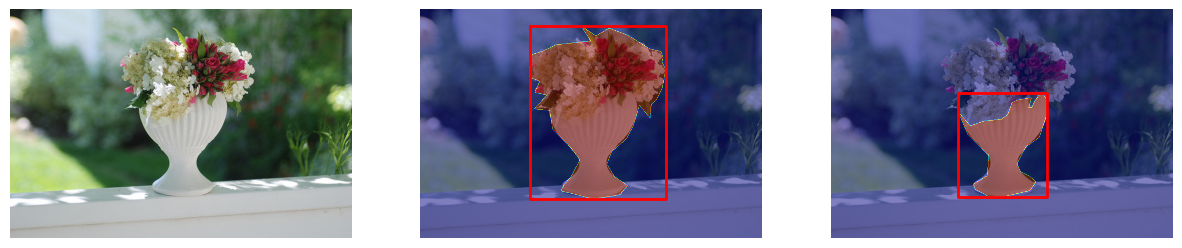

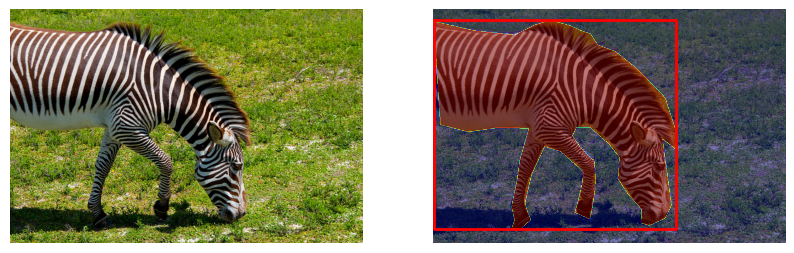

In [6]:
images_to_show =2
offset=2
scale=5

for i in range(images_to_show):
    item = data_train[offset+i]
    img = item[0]
    metadata = item[1]

    num_imgs = len(metadata)+1
    fig, axes = plt.subplots(1, num_imgs, figsize=(num_imgs * scale,  scale))
    axes=axes.flatten()

    for i,ax in enumerate(axes):
        if i==0: #straight up image
            ax.imshow(img)
            ax.axis('off')

        else: #+ masks
            rle = metadata[i-1]
            mask = api.annToMask(rle)
            ax.axis('off')
            ax.imshow(img)
            ax.imshow(mask, cmap='jet', alpha=0.5)

            box = utils.box_coco_to_sam(rle['bbox'])
            utils.plot_box(box,ax)

    plt.show()



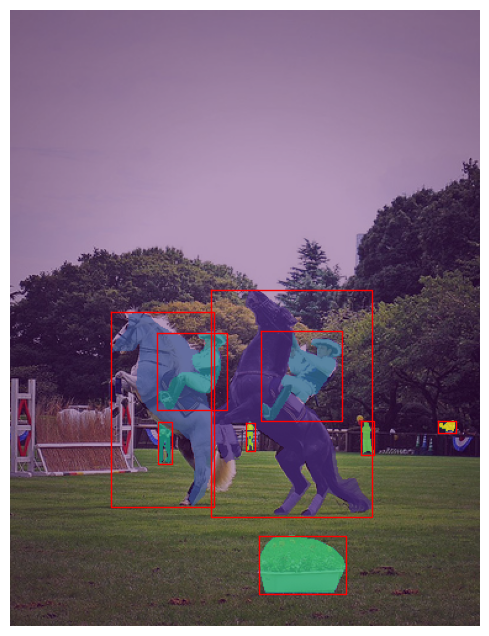

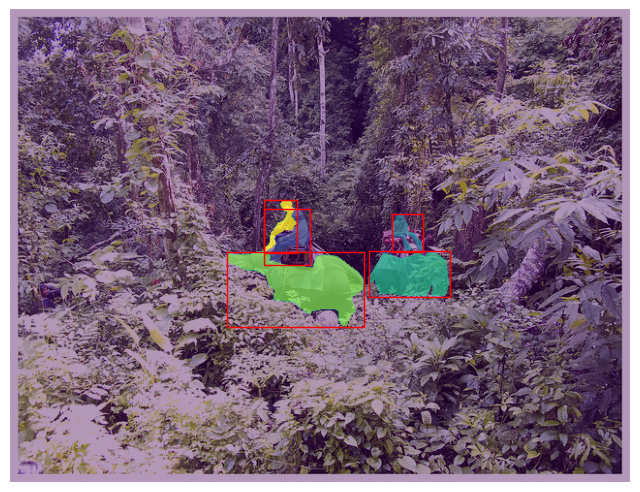

In [7]:
images_to_show =2
offset=6
scale=8
opacity=0.8
BG_MASK=True


for i in range(images_to_show):
    item = data_train[offset+i]
    img = item[0]
    metadata = item[1]

    plt.figure(figsize=(scale, scale))
    plt.imshow(img) #first image
    plt.axis('off')

    cmap =colormaps['autumn']
    num_images = len(metadata)

    mask_sum = np.zeros_like(img)[:,:,0]
    for i,rle in enumerate(metadata):
        mask = api.annToMask(rle)
        mask_sum = np.maximum(mask_sum,mask*(i+1))

    alpha = np.ones_like(img)[:,:,0]*opacity
    if not BG_MASK: alpha[np.where(mask_sum==0)] = 0
    else: alpha[np.where(mask_sum==0)] = opacity/2
    plt.imshow(mask_sum, cmap='viridis', alpha=alpha) 

    for i,rle in enumerate(metadata): #all masks
        box = utils.box_coco_to_sam(rle['bbox'])  #still x0,y0,w,h boxes here!!
        utils.plot_box(box,plt.gca(),linewidth=1)

    plt.show()


### Testing crop function

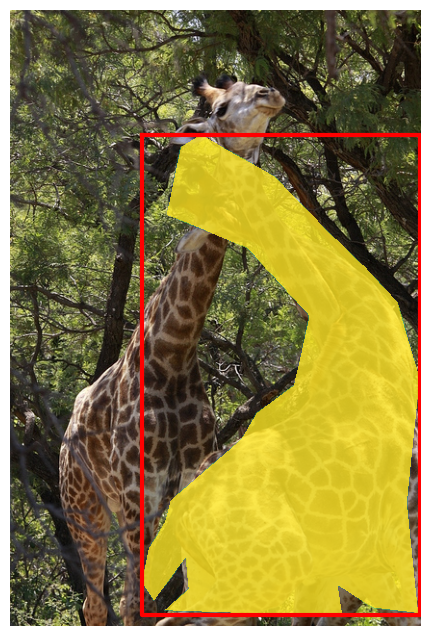

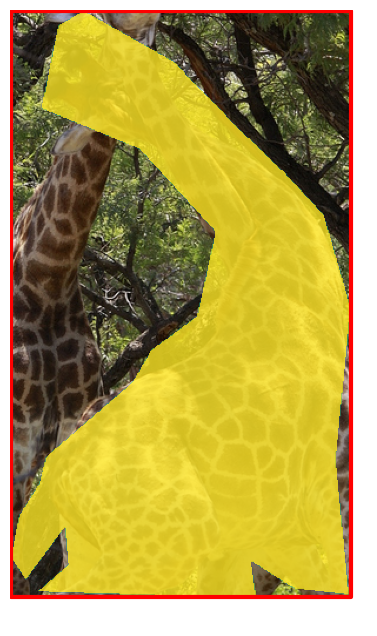

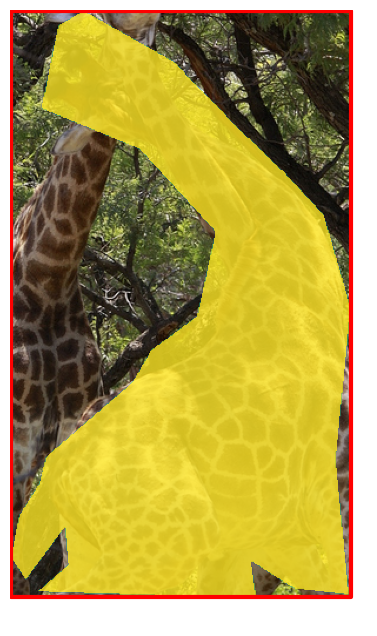

In [8]:
#all crops work? on PIL Image and numpy array

img = data_train[10][0] 
metadata = data_train[10][1]

gt_masks = utils.get_coco_masks(metadata, api)
gt_bboxes = utils.get_coco_boxes(metadata)

#img=np.asarray(img)
mask=gt_masks[0]
box=gt_bboxes[0]

utils.print_masks_boxes([mask], [box], img)

x0,y0=box[0],box[1]
w,h = box[2]-box[0],box[3]-box[1]
cropped_img,cropped_mask,cropped_box = utils.visual_utils.crop_xywh(img,mask,box,x0,y0,w,h)
utils.print_masks_boxes([cropped_mask], [cropped_box], cropped_img)

x1,y1 = box[2],box[3]
cropped_img,cropped_mask,cropped_box = utils.crop_xyxy(img,mask,box,x0,y0,x1,y1)
utils.print_masks_boxes([cropped_mask], [cropped_box], cropped_img)
#NOTE: should produce the same picture